# Lesson 17

The course repo: 
[Course Repo](https://github.com/fastai/course22p2)

Initialization and Normalization.

## But First...
The video discusses some changes to the callback class. However I think these were further overridden later, where he passes in learn as an argument.  He also added TrainLearner, which is a less flexible learner but ready to go for simple cases.  This is in the 'minai' library.

He also discussed some changes to the activations notebook, in particular the HooksCallback which was also already in the notebook by the time we got to it. I find this a bit confusing.  

He also added ActivationStats which is a subclass of HooksCallback.  This is in the 'minai' library. This adds `color_dim` , `dead_chart` and `plot_stats`  (See code)

There were some other changes made that even Jeremy was not sure if he discussed.

In my 'minai' library I added also the activation functions and tools from lesson 16. I copied this code from the repo except removed all the nbs hooks.




## Reading in the libraries

In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from minai.datasets import *
from minai.conv import *
from minai.learner import *
from minai.activations import *

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

## Initialization notebook 
Notebook 11 
Goal: 90% or more on Fashion MNIST

In [2]:
## Read in data gain
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

Again with the rediculously simple classifier model

In [3]:
def get_model():
    return nn.Sequential(conv(1 ,8), conv(8 ,16), conv(16,32), conv(32,64),
                         conv(64,10, act=False), nn.Flatten()).to(def_device)

The learning rate finder needs to be adjusted for this model. With defaults it doesn't help much at all.

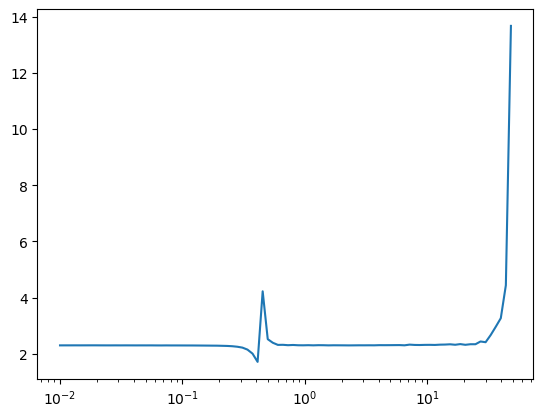

In [4]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

In [5]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.273,1.969,0,train
0.622,0.931,0,eval


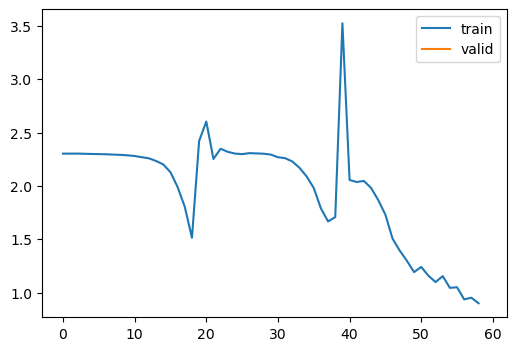

In [6]:
learn.fit(1)

Training is not going to well at all. Activations are crashing. He said he tried various learning rates

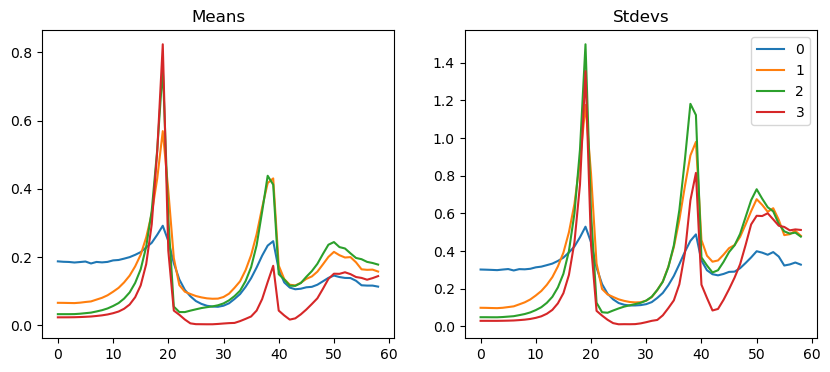

In [7]:
astats.plot_stats()

The key problem is that we dont have zero mean and unit variance at the start even, much less throughouth the layers. 

### GPU memory and jupyter

* Jupyter notebook keeps a history of previous evaluations in `_` and `__` and `___` etc. This can take up keep memory from being gc'd. So if one of your outputs is a cuda tensor, this can cause a problem. 

* Cuda erros can cause tracebacks to also hold onto memory! 

To help with these issues, Jeremy gives us these functions:

In [8]:
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

### Why mean 0 and variance 1?

* Problem is that the activations, even if they start out normalized, layer after layer they can get out of control, tending toward 0 or infinity.  You have to scale the weights 'just right' to keep the activations in a good range.

* See paper : [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

* This leads to the idea of 'Xavier initialization' which is a way to initialize the weights so that the activations stay normalized.  The right scale is $\frac{1}{\sqrt{n}}$ where n is the number of inputs to the layer. 

In [9]:
x = torch.randn(200,100)  # initial activation
for i in range(50): x = x @ (torch.randn(100,100)/math.sqrt(100))
x.mean(),x.std()

(tensor(-0.01), tensor(0.80))

I wonder how sensitive that is?  Seems quite sensitive! This will lead to the idea of layer / batch normalization.

In [10]:
x = torch.randn(200,100)  # initial activation
for i in range(50): x = x @ (torch.randn(100,100)/math.sqrt(100))*0.9
x.mean(),x.std()

(tensor(    0.00), tensor(0.01))

### Xavier initialization

* At this point he does a side discussion on what variance / covariance actually is.  
* THen does a quick look 'derivation' of the Xavier initialization by computing  the mean and standard devation of the activations after one layer.

In [11]:
x= torch.randn(200,100)  # initial activation
x2 = x @ (torch.randn(100,100))
x2.mean(),x2.std()

(tensor(-0.08), tensor(9.95))

So we can see that the standard deviation is of size $\sqrt{n}$ and the mean is 0.  So we want to scale the weights so that the standard deviation is 1.  This is where the $\frac{1}{\sqrt{n}}$ comes from.

However, this is all great but doesn't quite work for us because we are using ReLU activations.  The ReLU activations are not symmetric around 0, so we need to adjust the scale.  This is where the Kaiming initialization comes in.

### Kaiming initialization

* Paper [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/abs/1502.01852)

* The answer is to scale the weights by $\frac{2}{\sqrt{n}}$ where n is the number of inputs to the layer.

* To use this, we can use `apply` which all nn modules have. We have to be careful to apply this only to modules that have weights.

In [12]:
model = get_model()

# interesting I did not know that isinstance can take a tuple of classes
def init_weights(m):
    if isinstance(m, (nn.Conv2d,nn.Conv1d, nn.Conv3d, nn.Linear)): init.kaiming_normal_(m.weight)

model.apply(init_weights);

### We also have to adjust our inputs to be normalized.

Note this is the new version, modified from what you presented, where each callback takes an additional 'learn' argument.

In [13]:
xmean,xstd = xb.mean(),xb.std()
xmean,xstd

(tensor(0.29), tensor(0.35))

Simple transformer on each batch. 

In [14]:
class BatchTransformCB(Callback):
    def __init__(self, tfm, on_train=True, on_val=True): fc.store_attr()

    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            learn.batch = self.tfm(learn.batch)

def _norm(b): return (b[0]-xmean)/xstd,b[1]
norm = BatchTransformCB(_norm)



Try the learning again

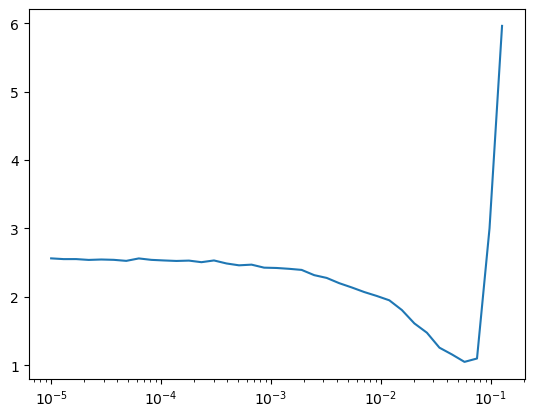

In [15]:
MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, cbs=[DeviceCB(), norm]).lr_find()

accuracy,loss,epoch,train
0.669,0.993,0,train
0.799,0.528,0,eval
0.834,0.455,1,train
0.835,0.443,1,eval
0.857,0.393,2,train
0.834,0.442,2,eval


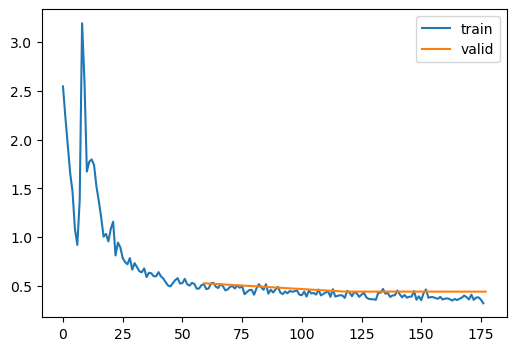

In [16]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.1, cbs=cbs+[norm])
learn.fit(3)

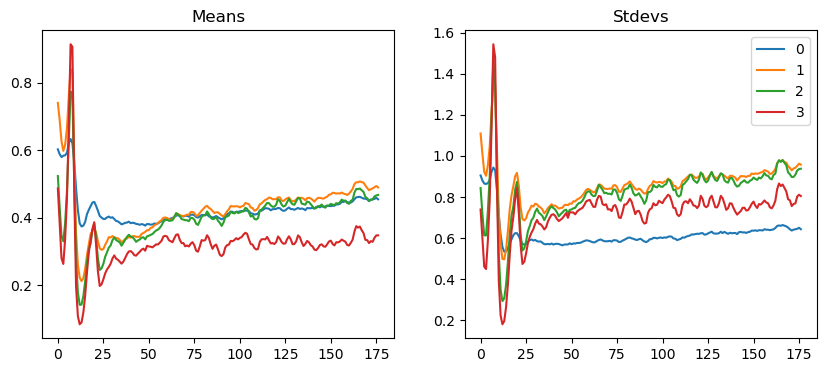

In [17]:
astats.plot_stats()

An alternative is to use the 'with_transform' of the hugging face library (modify our `transformi`).  

### QUESTION: Why is the training accuracy a bit LOWER than the validation accuracy? 

He doesnt print out the validation stuff in the video at this point so not sure.

### Relu and mean 0

* Due to the ReLU activations, the mean of the activations cannot be zero. (The negative values are clipped to zero). 

* An alternative is to use a 'General ReLU' activation function wich subtracts some given value from the activations to allow a mean of zero.

* Also we will make this a 'Leaky ReLU' which allows some negative values to pass through, to avoid completely zero activations (dead units)



In [18]:
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

lets use this:

In [19]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None), nn.Flatten()).to(def_device)

# Take into consideration the leakiness in the initialization of weights
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight, a=leaky)



accuracy,loss,epoch,train
0.685,0.889,0,train
0.836,0.455,0,eval
0.854,0.397,1,train
0.861,0.390,1,eval
0.870,0.354,2,train
0.864,0.377,2,eval


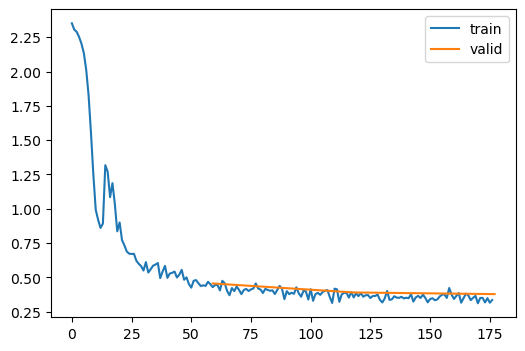

In [20]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)  # leaky relu with offset 0.4
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)


model = get_model(act_gr).apply(iw)


learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

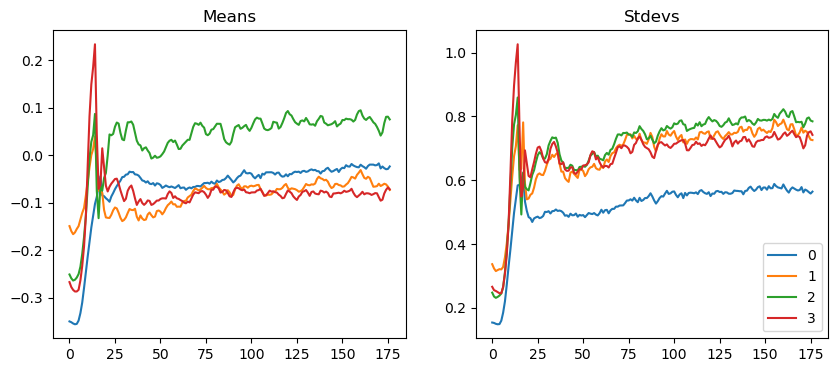

In [21]:
astats.plot_stats()

Now our mean is zero and our standard deviation is just under 1

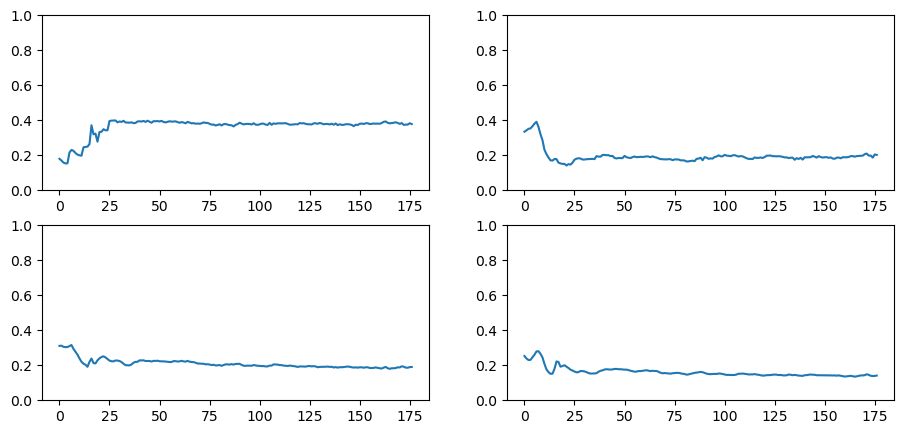

In [22]:
astats.dead_chart()

### LSUV

This is suprising how much this helps. The model is now training well..   THe big thing here was the initialization!  The generalized relu helped a bit.

[All you need is a good init](https://arxiv.org/abs/1511.06422) - Simple idea is to set up your model, and check the activations, if they are not normalized, then you need to adjust your initialization until they are. One layer at a time.  This is called "Layer-wise Sequential Unit-Variance" initialization, or LSUV.

In [ ]:
# This is the actual hook. it will be called for each module it is registered on to compute the output stats.
def _lsuv_stats(hook, mod, inp, outp):
    acts = to_cpu(outp)
    hook.mean = acts.mean()
    hook.std = acts.std()

# this function is called with the model, and also `m` which is the module we want the output for and
# `m_in` which is the input module of `m` (the previous layer, i.e. convolution layer)
def lsuv_init(model, m, m_in, xb):
    h = Hook(m, _lsuv_stats) # register the hook with the output layer (ReLU or other activation)
    with torch.no_grad():
        #count = 0
        while model(xb) is not None and (abs(h.std-1)>1e-3 or abs(h.mean)>1e-3):
            m_in.bias -= h.mean
            m_in.weight.data /= h.std
            #count += 1
            #print (count, h.mean, h.std)
    h.remove()

In [28]:
model = get_model(act_gr)
relus = [o for o in model.modules() if isinstance(o, GeneralRelu)]
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]

Note that we are only doing this on the first batch.  I am not sure how this is justified, Jeremy doesnt say
Also we are adjusting each layer, one at a time. The adjustment of the earlier layers effects the other layers, hence 'layerwise'. 

Note that it takes mulitple passes because subtracting the mean from the bias and then dividing the weights by the standard deviation doesn't make the activations unit variance.  So we have to do this multiple times.

In [30]:
for ms in zip(relus,convs): lsuv_init(model, *ms, xb.to(def_device))

accuracy,loss,epoch,train
0.772,0.648,0,train
0.840,0.437,0,eval
0.865,0.371,1,train
0.860,0.381,1,eval
0.882,0.324,2,train
0.870,0.361,2,eval


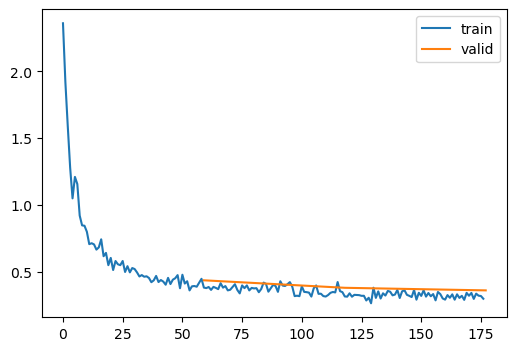

In [26]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

Nearly as good (or perhaps even as good within noise)

###  Batch norm

* Ioffe and Szegedy 2015 [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

* Key idea is to make normalization part of the model architecture and perform the normalization on each batch.

### BUT FIRST,  Layer Normalization

* Simpler to understand so we will start with this.

* Ba et al 2016 [Layer Normalization](https://arxiv.org/abs/1607.06450)

* The idea is best seen in code:

In [31]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))  # learnable parameter
        self.add  = nn.Parameter(tensor(0.))  # learnable parameter

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True) #NCHW, mean over CHW only 
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())  # normalize, eps is to avoid division by zero
        return x*self.mult + self.add # learnable parameters to scale and shift the normalized x

Try it out

In [32]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)

accuracy,loss,epoch,train
0.763,0.665,0,train
0.839,0.450,0,eval
0.855,0.396,1,train
0.858,0.391,1,eval
0.873,0.347,2,train
0.858,0.392,2,eval


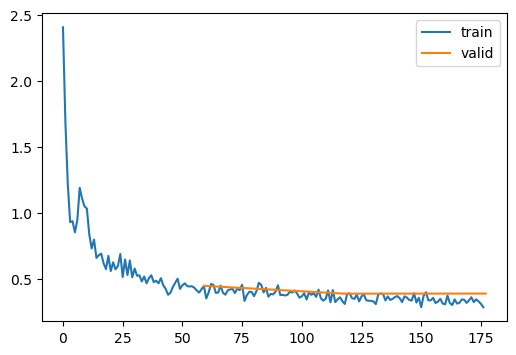

In [33]:
set_seed(42)
model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

Seeme to work jsut as well as LSUV, and easier! 

But people are realizing that these new learnable parameters are creating complexity and so recently people are going back to initialization correctly to avoid these layers. They are not a silver bullet.


### Batch Norm

In [34]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1)) # learnable parameters, one for every channel 
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))


    # exponentially weighted moving average 
    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True) # mean is over batch, width and height . 
        v = x.var ((0,2,3), keepdim=True)
        # lerp - linear interpolation. mom is the weight for the new value, 1-mom is the weight for the old value
        # recall underscore in pytorch means in-place operation
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds  #rescale and shift

Note that:
* During inference we just use the saved means and standard deviations
* Buffers in pytorch are non-trainable variables that are saved in the model.   NOT a parameter.

NOte the increased learning rate!

accuracy,loss,epoch,train
0.790,0.575,0,train
0.790,0.601,0,eval
0.871,0.351,1,train
0.853,0.429,1,eval
0.885,0.309,2,train
0.865,0.367,2,eval


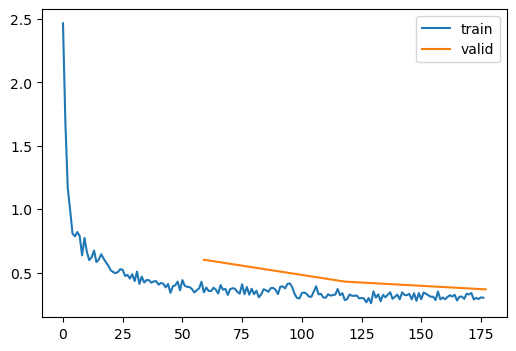

In [35]:
model = get_model(act_gr, norm=BatchNorm).apply(iw)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs)
learn.fit(3)

Various norm types:

![Various norms](images/norms.png)

Instance norm just normalizes over a single channel and single image. 

Group norm does several ('group') channels at once, but not the whole layer. (The picture is from the Group Norm paper: [Group Normalization](https://arxiv.org/abs/1803.08494))


### Towards 90% 

* Lets use pytorches batch norm, nothing wrong with ours but no reason to use it now that we see how it works
* Use a smaller batch size 

accuracy,loss,epoch,train
0.836,0.450,0,train
0.863,0.373,0,eval
0.882,0.322,1,train
0.882,0.338,1,eval
0.893,0.291,2,train
0.855,0.394,2,eval


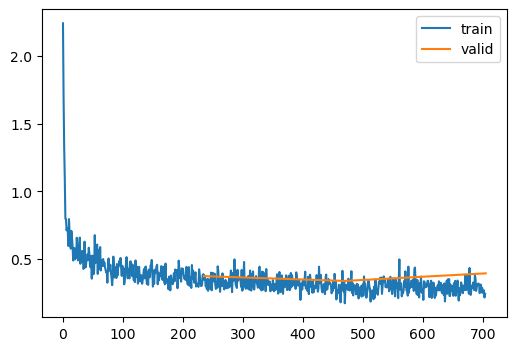

In [36]:
dls = DataLoaders.from_dd(tds, 256, num_workers=4)
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

accuracy,loss,epoch,train
0.914,0.236,0,train
0.898,0.282,0,eval
0.918,0.222,1,train
0.894,0.286,1,eval
0.920,0.215,2,train
0.899,0.281,2,eval


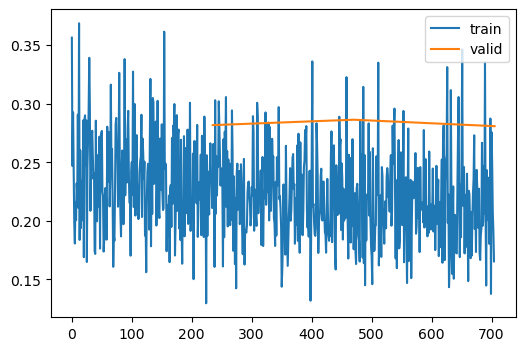

In [37]:
# train some more with a smaller learning rate
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.05, cbs=cbs)
learn.fit(3)

Up to 89.9%  on validation data, getting close!

## Accelerated SGD training!

1:29 in the video

Reimporting things here. This is notebook 12.  THe stuff above goes into minai.init

In [1]:
import torch
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from minai.datasets import *
from minai.conv import *
from minai.learner import *
from minai.activations import *
from minai.init import *

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [3]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

### SGD 


This is just what we have been doing all along, except we have been using the torch version in `optim`. We make it explicit so we can see how to improve it.

In [7]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params)
        fc.store_attr()
        self.i = 0  # batch counter

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i +=1

    def opt_step(self, p): p -= p.grad * self.lr

    # weight decay regularizer
    def reg_step(self, p): 
        if self.wd != 0: p *= 1 - self.lr*self.wd

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [5]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD)

accuracy,loss,epoch,train
0.769,0.647,0,train
0.824,0.495,0,eval
0.843,0.431,1,train
0.840,0.442,1,eval
0.862,0.380,2,train
0.856,0.401,2,eval


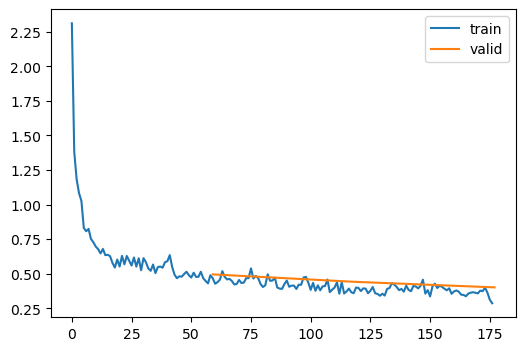

In [6]:
learn.fit(3)

### Regularization reminder

* We discussed weight decay / L2 regularization in the Part 1.  Recall that adding the squared weights turns into a weight decay when we take the derivative.

* This helps to prevent overfitting.  It is a bit like a prior that says 'smaller weights are better'.


### Momentum 

* basically an exponential running average of the gradients. 

* This helps to keep the gradients from jumping around too much.  Not this does add a bit of a delay, responding to how things were in the past.

In [ ]:
class Momentum(SGD):
    def __init__(self, params, lr, wd=0., mom=0.9):
        super().__init__(params, lr=lr, wd=wd)
        self.mom=mom

    def opt_step(self, p):
        # note the trick of stashing the grad_avg in the parameter itself
        if not hasattr(p, 'grad_avg'): p.grad_avg = torch.zeros_like(p.grad)
        p.grad_avg = p.grad_avg*self.mom + p.grad*(1-self.mom)
        p -= self.lr * p.grad_avg

accuracy,loss,epoch,train
0.788,0.586,0,train
0.847,0.423,0,eval
0.866,0.369,1,train
0.865,0.380,1,eval
0.883,0.320,2,train
0.872,0.355,2,eval


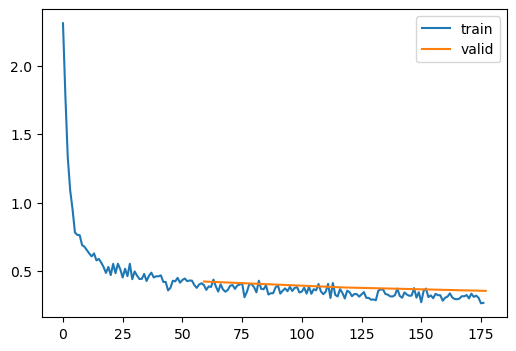

In [18]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
#note the much higher learning rate, everything is much smoother
learn = TrainLearner(model, dls, F.cross_entropy, lr=1.5, cbs=cbs, opt_func=Momentum)

learn.fit(3)

Really smoothest we have seen so far in the weights.

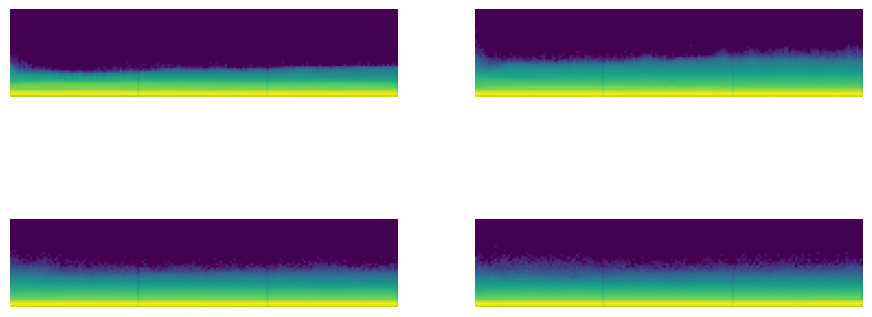

In [11]:
astats.color_dim()

### RMS Prop 

* Idea here to use gradient square, since a large square indicates a large variance. 
* So we devide by the square root of the moving average of the squares of the gradients. (RMS)

In [12]:
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.sqr_mom,self.eps = sqr_mom,eps

    def opt_step(self, p):
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = p.grad**2
        p.sqr_avg = p.sqr_avg*self.sqr_mom + p.grad**2*(1-self.sqr_mom)
        p -= self.lr * p.grad/(p.sqr_avg.sqrt() + self.eps)

accuracy,loss,epoch,train
0.769,0.659,0,train
0.826,0.484,0,eval
0.848,0.417,1,train
0.838,0.449,1,eval
0.864,0.372,2,train
0.858,0.398,2,eval


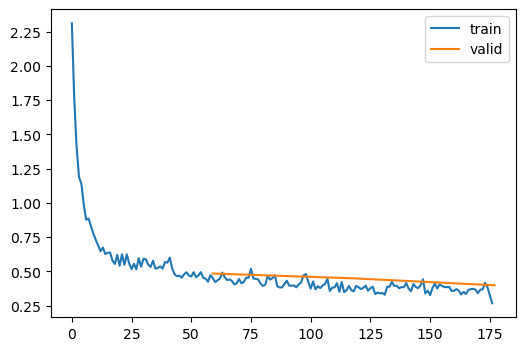

In [ ]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
# we have to decrease the learnign rate due to the division by the square root of the average squared gradient
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=RMSProp)
learn.fit(3)

### Adam 

* Kingma and Ba 2015 [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980)

* This is a combination of RMSProp and Momentum.  It is the most popular optimizer right now.

In [ ]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1,self.beta2,self.eps = beta1,beta2,eps

    def opt_step(self, p):
        if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)
        p.avg = self.beta1*p.avg + (1-self.beta1)*p.grad
        unbias_avg = p.avg / (1 - (self.beta1**(self.i+1)))  # bias correction, depends on the batch number
        p.sqr_avg = self.beta2*p.sqr_avg + (1-self.beta2)*(p.grad**2)
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i+1)))
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

To understand the unbiasing, lets focus in on the exponential moving average.

$avg_t = \beta \cdot  avg_{t-1} + (1-\beta) g_t$


lets expand thsi out for a fue steps:

$avg_t = (1-\beta) g_t + \beta \cdot (1-\beta) g_{t-1} + \beta^2 \cdot (1-\beta) g_{t-2} + \beta^3 \cdot (1-\beta) g_{t-3} + ... + \beta^t (1-\beta) g_{0}$ 

If we sum up all the weights, we should get 1, but we don't.  We can do this using the geometric series formula, to get:

$\sum_{i=0}^t \beta^i (1-\beta) = 1 - \beta^{t+1}$ 

So to unbias we need to divide by $1 - \beta^{t+1}$.  For later steps this is close to one, but for the first few steps it is not.  This is why we need to unbias.


accuracy,loss,epoch,train
0.796,0.574,0,train
0.843,0.433,0,eval
0.868,0.363,1,train
0.867,0.373,1,eval
0.884,0.318,2,train
0.873,0.349,2,eval


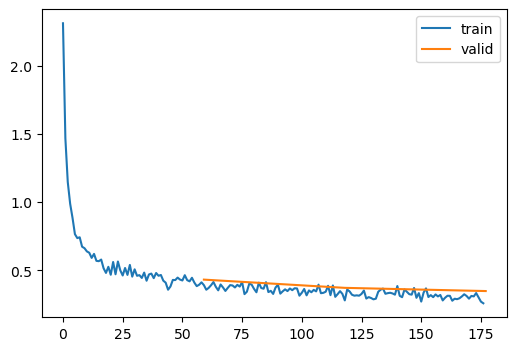

In [17]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=Adam)
learn.fit(3)

### Next time, we will continue on with optimizing and will get above 90% 

### Note on batch size

* Smaller batch sizes give more opportunities for the optimizer to update the weights.  This can be good, but it can also be bad because the gradients are noisier. However momentum can help here.
* Smaller batch sizes are also of course slower to train.
* Generally, you want to use the smallest batch size that you can get away with.